# Założenia projektu

### Przewidywanie ceny domów. Celem projektu jest zastosowanie modeli regresji do przewidzenia ceny domu o podanych cechach.

Data: <b>06-09-2019</b> Imię i nazwisko: <b>Marek Hulbój</b><br><br>



Link do danych: <a href>web.stanford.edu/class/stats191/data/ames2000_NAfix.csv</a><br>
Dokładny opis danych: http://web.stanford.edu/class/stats191/data/amesdoc.txt<br><br>
Zmienna celu (cena domu): SalePrice

Wymagania dla projektu:
    
● Musi zostać wykorzystany model regresji liniowej.<br>
● Muszą zostać wykorzystane przynajmniej dwie inne metody regresji: regresja Ridge, regresja Lasso, drzewo regresyjne, las losowy regresyjny, XGBoost lub inne).<br>
● Trzeba uwzględnić optymalizację modeli/pipelinów.<br>
● Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.<br>
● Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze zmiennej tym, że rozkład jest skośny).<br>
● Musi pojawić się ocena graficzna predykcji modeli (np. wykresy wartości przewidywanych od prawdziwych czy wykresy reziduów).<br>
● Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

# Import modułów

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat
import time
from scipy import stats
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor


# przy pierwszym przebiegu przeanalizowano ostrzeżenia - zostały tylko deprecation warning z bibliotek, dla lepszej estetyki zostały wyłączone
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)
%matplotlib inline

# Import danych do modelu

In [2]:
data = pd.read_csv("data/ames2000_NAfix.csv")

In [3]:
data.shape

(2000, 80)

In [4]:
data.sample(15)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
78,30,RM,50,8635,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,5,5,1925,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0,TA,Fa,BrkTil,TA,TA,No,LwQ,134,Unf,0,938,1072,GasA,TA,Y,SBrkr,1072,0,0,1072,1,0,1,0,2,1,TA,5,Typ,0,None,Detchd,1982,Unf,5,1184,Fa,TA,P,0,0,105,0,0,0,None,None,None,0,8,2009,WD,Normal,126500
1069,50,RL,80,12400,Pave,None,Reg,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,1Fam,1.5Fin,5,6,1940,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,CBlock,Gd,TA,Mn,BLQ,602,Unf,0,299,901,GasA,TA,Y,SBrkr,1125,592,0,1717,0,0,1,1,2,1,TA,7,Typ,1,Gd,Attchd,1940,Unf,1,410,TA,TA,Y,0,0,0,0,113,0,None,None,None,0,2,2006,WD,Normal,194000
767,90,RL,76,9482,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Nonemes,Norm,Norm,Duplex,1Story,5,4,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,657,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,1866,1866,GasA,Ex,Y,SBrkr,1866,0,0,1866,0,0,2,0,4,2,TA,8,Typ,0,None,Detchd,1958,Unf,2,495,TA,Fa,Y,0,0,0,0,0,0,None,None,None,0,12,2009,WD,Normal,135000
1482,20,RL,62,9858,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,6,1968,1968,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,TA,TA,No,BLQ,510,Unf,0,354,864,GasA,TA,Y,SBrkr,874,0,0,874,1,0,1,0,3,1,TA,5,Typ,0,None,Attchd,1968,RFn,1,288,TA,TA,Y,33,0,0,0,0,0,None,GdWo,Shed,600,11,2009,WD,Normal,130000
367,20,RL,None,19900,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Nonemes,PosA,Norm,1Fam,1Story,7,5,1970,1989,Gable,CompShg,Plywood,Plywood,BrkFace,287,TA,TA,CBlock,Gd,TA,Gd,GLQ,912,Unf,0,1035,1947,GasA,TA,Y,SBrkr,2207,0,0,2207,1,0,2,0,3,1,TA,7,Min1,1,Gd,Attchd,1970,RFn,2,576,TA,TA,Y,301,0,0,0,0,0,None,None,None,0,7,2010,WD,Normal,180000
1734,60,RL,92,12003,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,2Story,8,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,BrkFace,84,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,0,774,774,GasA,Ex,Y,SBrkr,774,1194,0,1968,0,0,2,1,4,1,Ex,8,Typ,1,Gd,BuiltIn,2009,Fin,3,680,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,5,2010,New,Partial,269500
1612,20,RL,None,10659,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Nonemes,Norm,Norm,1Fam,1Story,5,6,1961,1961,Hip,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,CBlock,TA,TA,No,Rec,915,Unf,0,135,1050,GasA,TA,Y,SBrkr,1050,0,0,1050,1,0,1,0,3,1,TA,6,Typ,0,None,Attchd,1961,Unf,1,368,TA,TA,Y,0,319,0,0,0,0,None,None,None,0,1,2006,COD,Normal,136500
1064,120,RL,61,8035,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,9,5,2006,2006,Gable,CompShg,MetalSd,MetalSd,BrkFace,165,Gd,TA,PConc,Ex,TA,Gd,GLQ,797,Unf,0,815,1612,GasA,Ex,Y,SBrkr,1612,0,0,1612,1,0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2006,Fin,2,556,TA,TA,Y,0,164,0,0,0,0,None,None,None,0,3,2007,WD,Normal,319900
1956,30,RL,50,5330,Pave,None,Reg,HLS,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,4,7,1940,1950,Hip,CompShg,VinylSd,VinylSd,None,0,Fa,TA,CBlock,TA,TA,No,LwQ,280,Unf,0,140,420,GasA,Gd,Y,SBrkr,708,0,0,708,0,0,1,0,2,1,Fa,5,Typ,0,None,None,None,None,0,0,None,None,Y,164,0,0,0,0,0,None,None,None,0,12,2009,WD,Normal,82500
390,20,RL,53,5470,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,3,5,1958,1958,Gable,CompShg,MetalSd,MetalSd,Non

# Przegląd danych

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0
X1st.Flr.SF,2000.0,1158.7155,379.701015,407.0,877.75,1088.0,1391.25,4692.0
X2nd.Flr.SF,2000.0,334.3805,427.519973,0.0,0.00,0.0,703.25,2065.0
Low.Qual.Fin.SF,2000.0,4.3790,42.555738,0.0,0.00,0.0,0.00,697.0
Gr.Liv.Area,2000.0,1497.4750,498.561719,407.0,1126.75,1447.5,1734.00,5642.0


In [7]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Wybrany przez Ciebie dataFrame ma " + str(df.shape[1]) + " kolumn.\n"      
            + str(mis_val_table_ren_columns.shape[0]) + " z nich ma braki.")
        return mis_val_table_ren_columns

In [8]:
missingi = missing_values_table(data)

Wybrany przez Ciebie dataFrame ma 80 kolumn.
9 z nich ma braki.


In [9]:
missingi

,Missing Values,% of Total Values
Mas.Vnr.Type,16,0.8
Bsmt.Exposure,3,0.2
BsmtFin.Type.2,2,0.1
Garage.Finish,2,0.1
Bsmt.Qual,1,0.0
Bsmt.Cond,1,0.0
BsmtFin.Type.1,1,0.0
Garage.Qual,1,0.0
Garage.Cond,1,0.0


Istnieje 9 kolumn zawierających wartości null. W celu ich uzupełnienia w pierwszym kroku należy je sprawdzić.

In [10]:
missingi_lista = list(missingi.transpose().columns)

In [11]:
missingi_lista

['Mas.Vnr.Type',
 'Bsmt.Exposure',
 'BsmtFin.Type.2',
 'Garage.Finish',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'BsmtFin.Type.1',
 'Garage.Qual',
 'Garage.Cond']

In [12]:
for item in missingi_lista:
    print(item, ':', data[item].unique())

Mas.Vnr.Type : ['Stone' 'None' 'BrkFace' nan 'BrkCmn' 'CBlock']
Bsmt.Exposure : ['Av' 'No' 'None' 'Gd' 'Mn' nan]
BsmtFin.Type.2 : ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ' nan]
Garage.Finish : ['RFn' 'Fin' 'Unf' 'None' nan]
Bsmt.Qual : ['Gd' 'TA' 'None' 'Ex' 'Fa' nan 'Po']
Bsmt.Cond : ['TA' 'None' 'Gd' 'Fa' 'Ex' nan 'Po']
BsmtFin.Type.1 : ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ' nan]
Garage.Qual : ['TA' 'None' 'Fa' 'Gd' nan 'Po' 'Ex']
Garage.Cond : ['TA' 'None' 'Gd' 'Fa' 'Po' nan 'Ex']


Każda z kolumn zawierających wartości nan zawiera również wartość ```None```. Można wnioskować, że jest to wartość przypisana rekordom, dla których nie ma takiej informacji. W związku z powyższym poprawną opcją wydaje się inputacja braków wartością ```None```. Wcześniej jednak, warto zachować kopię danych przed ich przeprocesowaniem.

# Wypełnienie braków w danych

In [13]:
data_org = data.copy()

In [14]:
for item in missingi_lista:
    data[item] = data[item].fillna('None')

In [15]:
missing_values_table(data)

Wybrany przez Ciebie dataFrame ma 80 kolumn.
0 z nich ma braki.


,Missing Values,% of Total Values


# Analiza kolumn tekstowych

W związku z faktem, iż w analizowanym zbiorze braki w danych oznaczone zostały poprzez ```None``` to możliwe jest, że przy wczytaniu danych jakaś kolumna z wartościami numerycznymi mogła zostać uznana za kolumnę z wartościami tekstowymi.

In [16]:
for col in data.columns:
    if data[col].dtype=="object":
        print(f"{col}\n")
        print(data[col].unique())
        print()
        print("*"*10+"\n")

MS.Zoning

['RL' 'RM' 'C (all)' 'FV' 'I (all)' 'A (agr)' 'RH']

**********

Lot.Frontage

['34' '70' '60' '64' '111' '50' '155' 'None' '55' '51' '42' '75' '52' '24'
 '59' '79' '85' '65' '58' '83' '84' '100' '80' '63' '89' '112' '38' '77'
 '174' '39' '87' '125' '44' '81' '86' '97' '93' '118' '102' '78' '57' '69'
 '67' '116' '68' '101' '48' '73' '43' '32' '92' '54' '76' '91' '88' '90'
 '95' '40' '71' '72' '62' '130' '82' '21' '120' '114' '99' '105' '104'
 '35' '47' '98' '53' '61' '66' '94' '41' '74' '110' '115' '36' '117' '134'
 '30' '141' '49' '96' '124' '37' '129' '128' '107' '33' '108' '182' '136'
 '56' '113' '103' '46' '149' '26' '109' '45' '313' '135' '121' '126' '133'
 '22' '153' '25' '150' '138' '140' '152' '106' '160' '195' '168' '28']

**********

Street

['Pave' 'Grvl']

**********

Alley

['None' 'Grvl' 'Pave']

**********

Lot.Shape

['Reg' 'IR1' 'IR2' 'IR3']

**********

Land.Contour

['Lvl' 'Bnk' 'Low' 'HLS']

**********

Utilities

['AllPub']

**********

Lot.Config

['Ins

Szybki przegląd zmiennych potwierdza przypuszczenie, w związku z powyższym najprostszą metodą będzie wypełnienie wartości ```None``` wartością 0 bez straty żadnej informacji, dzięki czemu możliwe będzie przekształcenie columny na kolumnę liczbową.

In [17]:
for col in data.columns:
    if data[col].dtype=="object":
        df_temp = data[col].loc[data[col] != "None"]
        sample = df_temp.sample(1).values[0]
        if sample.isdigit():
            data.loc[data[col][data[col] == 'None'].index, col ] = 0
            data[col] = data[col].astype('int64')

In [18]:
for col in data.columns:
    if data[col].dtype=="object":
        print(f"{col}\n")
        print(data[col].unique())
        print()
        print("*"*10+"\n")

MS.Zoning

['RL' 'RM' 'C (all)' 'FV' 'I (all)' 'A (agr)' 'RH']

**********

Street

['Pave' 'Grvl']

**********

Alley

['None' 'Grvl' 'Pave']

**********

Lot.Shape

['Reg' 'IR1' 'IR2' 'IR3']

**********

Land.Contour

['Lvl' 'Bnk' 'Low' 'HLS']

**********

Utilities

['AllPub']

**********

Lot.Config

['Inside' 'Corner' 'CulDSac' 'FR2' 'FR3']

**********

Land.Slope

['Gtl' 'Sev' 'Mod']

**********

Neighborhood

['NridgHt' 'Nonemes' 'CollgCr' 'SawyerW' 'Sawyer' 'ClearCr' 'OldTown'
 'SWISU' 'Crawfor' 'Edwards' 'Timber' 'Gilbert' 'NoRidge' 'NWAmes'
 'BrkSide' 'Somerst' 'StoneBr' 'IDOTRR' 'Mitchel' 'MeadowV' 'NPkVill'
 'Blmngtn' 'Veenker' 'BrDale' 'Greens' 'Blueste' 'GrnHill']

**********

Condition.1

['Norm' 'Feedr' 'RRAn' 'Artery' 'PosN' 'PosA' 'RRAe' 'RRNn' 'RRNe']

**********

Condition.2

['Norm' 'PosN' 'RRAn' 'Artery' 'Feedr' 'PosA' 'RRNn']

**********

Bldg.Type

['Twnhs' '1Fam' 'Duplex' '2fmCon' 'TwnhsE']

**********

House.Style

['1Story' 'SFoyer' '2Story' '1.5Fin' 'SLvl' '

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null int64
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       2

Powtórna weryfikacja listy potwierdza, że udało się przekształcić kolumny zawierające numery przechowywane jako string w kolumny typu int64

# Data cleaning

Kolumna ```Lot.Frontage``` zawiera informację o odległości od ulicy. Z racji faktu, iż dom nie może stać dokładnie na granicy działki, a więc przylegać do ulicy braki w tej kolumnie (przyjmujące wartość 0) rozsądnie byłoby wypełnić medianą.

In [20]:
mediana = np.int64(data["Lot.Frontage"].astype(np.int64).median())
data["Lot.Frontage"].loc[data["Lot.Frontage"][data["Lot.Frontage"] == 0].index] = mediana

Podobnie wygląda sytuacja z kolumną ```Garage.Yr.Blt``` występują tam wartości 0, ale zamiast przyjmować tam średnie czy mediany, można założyć, że garaż prawdopodobnie został wybudowany razem z budynkiem. Kolumna zawierająca informacje o roku budowy nie zawierała ```None``` więc można wypełnić rok budowy garażu tą wartością

In [21]:
data.loc[data["Garage.Yr.Blt"][data["Garage.Yr.Blt"] == 0].index, "Garage.Yr.Blt"] = data.loc[data["Garage.Yr.Blt"][data["Garage.Yr.Blt"] == 0].index, "Year.Built"]

# Label encoding

Algorytmy ML przyjmują liczby, w związku z czym należy dokonać przekształcenia zmiennych jakościowych wyrazonych tekstem na liczby. Zamiast żmudnego budowania słownika do tego celu zostanie wykorzystany LabelEncoder.

In [22]:
for col in data.columns:
    if data[col].dtype == "object":
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

Dodatkowo warto sprawdzić czy wszystkie wartości tekstowe zostały przekształcone na numeryczne

In [23]:
data.sample(5)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
722,60,2,85,10625,1,1,3,3,0,4,0,23,2,2,0,5,6,5,2004,2004,1,1,11,13,1,353,2,3,2,2,5,0,6,0,6,0,1158,1158,1,0,1,3,1158,1285,0,2443,0,0,2,1,4,1,2,9,3,1,2,3,2004,2,3,744,5,5,2,193,127,0,0,0,0,3,4,1,0,6,2007,9,4,265000
1227,160,6,21,1869,1,1,3,3,0,4,0,2,2,2,3,5,6,6,1970,1970,1,1,6,6,1,127,3,3,1,5,5,3,5,321,6,0,162,483,1,4,1,3,483,504,0,987,0,0,1,1,2,1,3,5,6,0,3,5,1987,3,1,280,5,5,2,0,0,0,0,0,0,3,4,1,0,9,2008,9,4,106000
1506,20,5,63,15387,1,1,0,3,0,1,0,15,2,2,0,2,7,7,1967,1967,1,1,8,10,3,0,3,3,1,5,5,3,0,603,1,294,723,1620,1,0,1,3,1620,0,0,1620,0,0,2,0,4,1,2,8,6,1,2,1,1967,3,2,578,5,5,2,0,62,192,0,0,0,3,4,3,450,8,2008,9,4,215000
224,180,6,35,3675,1,1,3,3,0,4,0,7,2,2,4,6,6,5,2005,2005,1,1,11,13,4,76,3,3,2,2,5,1,2,467,6,0,80,547,1,0,1,3,1072,0,0,1072,1,0,1,0,2,1,2,5,6,0,3,2,2005,0,2,525,5,5,2,0,44,0,0,0,0,3,4,1,0,5,2007,9,4,140000
203,20,5,63,8780,1,1,0,3,0,0,0,13,2,2,0,2,5,5,1985,1985,1,1,6,10,3,0,3,3,1,5,5,3,0,625,6,0,208,833,1,0,1,3,833,0,0,833,1,0,1,0,3,1,3,5,6,0,3,6,1985,1,0,0,3,3,2,0,0,0,0,0,0,3,2,1,0,3,2009,9,4,112000


In [24]:
data.dtypes

MS.SubClass        int64
MS.Zoning          int64
Lot.Frontage       int64
Lot.Area           int64
Street             int64
Alley              int64
Lot.Shape          int64
Land.Contour       int64
Utilities          int64
Lot.Config         int64
Land.Slope         int64
Neighborhood       int64
Condition.1        int64
Condition.2        int64
Bldg.Type          int64
House.Style        int64
Overall.Qual       int64
Overall.Cond       int64
Year.Built         int64
Year.Remod.Add     int64
Roof.Style         int64
Roof.Matl          int64
Exterior.1st       int64
Exterior.2nd       int64
Mas.Vnr.Type       int64
Mas.Vnr.Area       int64
Exter.Qual         int64
Exter.Cond         int64
Foundation         int64
Bsmt.Qual          int64
Bsmt.Cond          int64
Bsmt.Exposure      int64
BsmtFin.Type.1     int64
BsmtFin.SF.1       int64
BsmtFin.Type.2     int64
BsmtFin.SF.2       int64
Bsmt.Unf.SF        int64
Total.Bsmt.SF      int64
Heating            int64
Heating.QC         int64


## Podsumowanie preprocessingu danych

Przeprowadzone procesy czyszczenia i uzupełniania danych były potrzebne w celu uzyskania poprawnych wyników. Analizowany zbiór zawierał w sobie kilka pułapek w które można łatwo było wpaść, które mogłyby mieć istotny wpływ na jakość zbudowanego modelu.

# Analiza rozkładu zmiennej objaśnianej

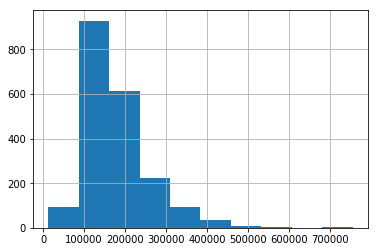

In [25]:
# rozkład zmiennej objaśnianej
data["SalePrice"].hist()
plt.show()

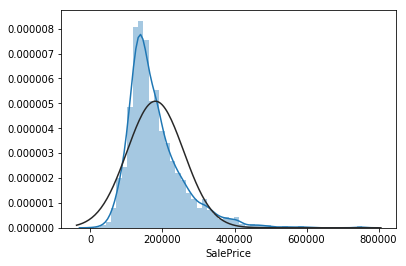

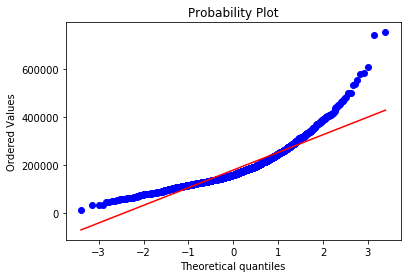

In [26]:
# rozkład zmiennej objaśnianej
sns.distplot(data["SalePrice"], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(data["SalePrice"], plot=plt)

Analiza wizualna rozkładu zmiennej objaśnianej pozwala przypuszczać, że mamy doczynienia z rozkładem prawostronnie skośnym. W tym celu zostanie przeprowadzony prosty test z wykorzystaniem miary skośności (różnica między średnią a medianą zbioru)

In [27]:
skew = round(data["SalePrice"].skew(), 2)
if skew == 0:
    wynik = "rozkład zmiennej jest symetryczny"
elif skew > 0:
     wynik = "rozkład zmiennej jest prawostronnie skośny"
elif skew < 0:
     wynik = "rozkład zmiennej jest lewostronnie skośny"
        
print(f"Współczynnik skośności wynosi: {skew} co oznacza, że {wynik}")

Współczynnik skośności wynosi: 1.74 co oznacza, że rozkład zmiennej jest prawostronnie skośny


Do znormalizowania rozkładu zmiennej objaśnianej zostanie wykorzystany logarytm naturalny.

In [28]:
data["SalePrice"] = np.log(data["SalePrice"])

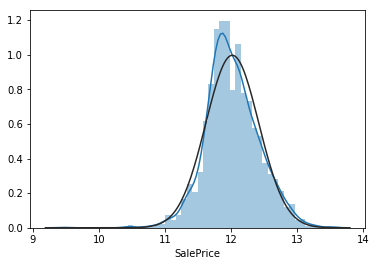

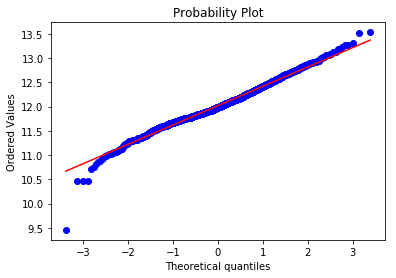

In [29]:
# rozkład zmiennej objaśnianej
sns.distplot(data["SalePrice"], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(data["SalePrice"], plot=plt)

In [30]:
skew = round(data["SalePrice"].skew(), 2)
if skew == 0:
    wynik = "rozkład zmiennej jest symetryczny"
elif skew > 0:
     wynik = "rozkład zmiennej jest prawostronnie skośny"
elif skew < 0:
     wynik = "rozkład zmiennej jest lewostronnie skośny"
        
print(f"Współczynnik skośności wynosi: {skew} co oznacza, że {wynik}")

Współczynnik skośności wynosi: 0.04 co oznacza, że rozkład zmiennej jest prawostronnie skośny


Po wykonaniu transformacji przy użyciu logarytmu naturalnego, rozkład jest już bardzo zbliżony do normalnego.

# Analiza korelacji zmiennych objaśniających ze zmienną objaśnianą

Co prawda większośc algorytmów machine learning sama nada wagi poszczególnym cechom w zależności od ich istotności. Warto jednak zweryfikować korelację liniową pomiędzy zmiennymi żeby sprawdzić czy któraś ze zmiennych nie jest podejrzana o data leak. Z racji faktu, iż analizowany zbiór ma 80 kolumn to szczegółowa analiza zostanie zawężona do kolumn, które mają przynajmniej umiarkowanie silną zależność, bez względu na to czy jest dodatnia czy ujemna. 

In [31]:
sp_correlation = data[data.columns[1:]].corr()['SalePrice'].abs().sort_values(ascending=False)

In [32]:
subset = data[sp_correlation.loc[sp_correlation>0.6].index]

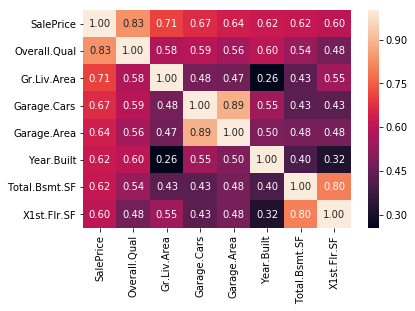

In [33]:
sns.heatmap(subset.corr(), annot=True, fmt=".2f")
plt.show()

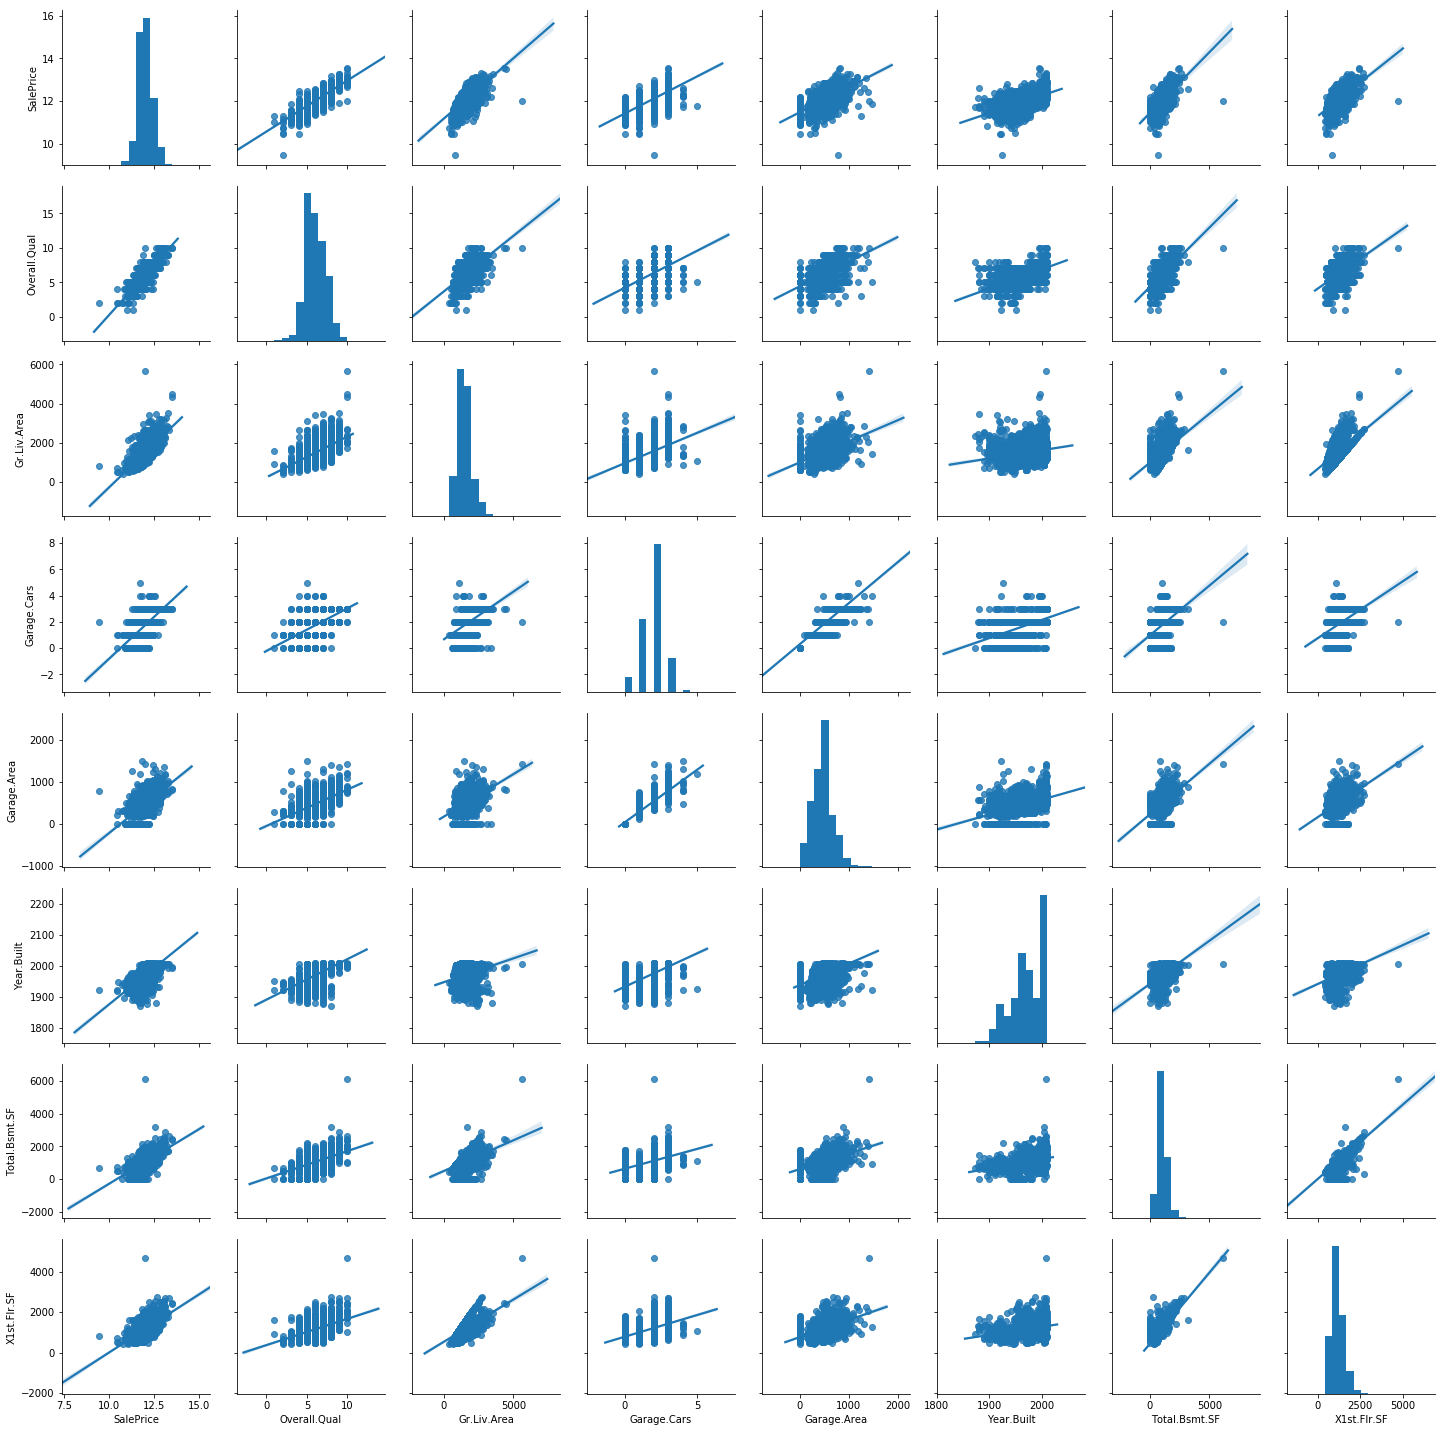

In [34]:
sns.pairplot(subset, kind="reg")

Wniosek: Największe znaczenie ma ogólny stan domu, garażu, piwnicy, kuchni, a także metraże poszczególnych elementów.

Najsilniejsza jest korelacja ceny 'SalePrice' z 'Overall.Qual'

# Train test split

In [35]:
# train test split
X = data.copy().drop(["SalePrice"], axis=1)
y = data["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Redukcja wymiarów

Z uwagi na fakt, iż analizowany zbiór ma 80 kolumn to żeby przyspieszyć proces budowy modelu zostanie przeprowadzona redukcja wymiarów. Aby ustalić liczbę komponentów, która niesie najwięcej informacji zostanie przeprowadzona analiza.

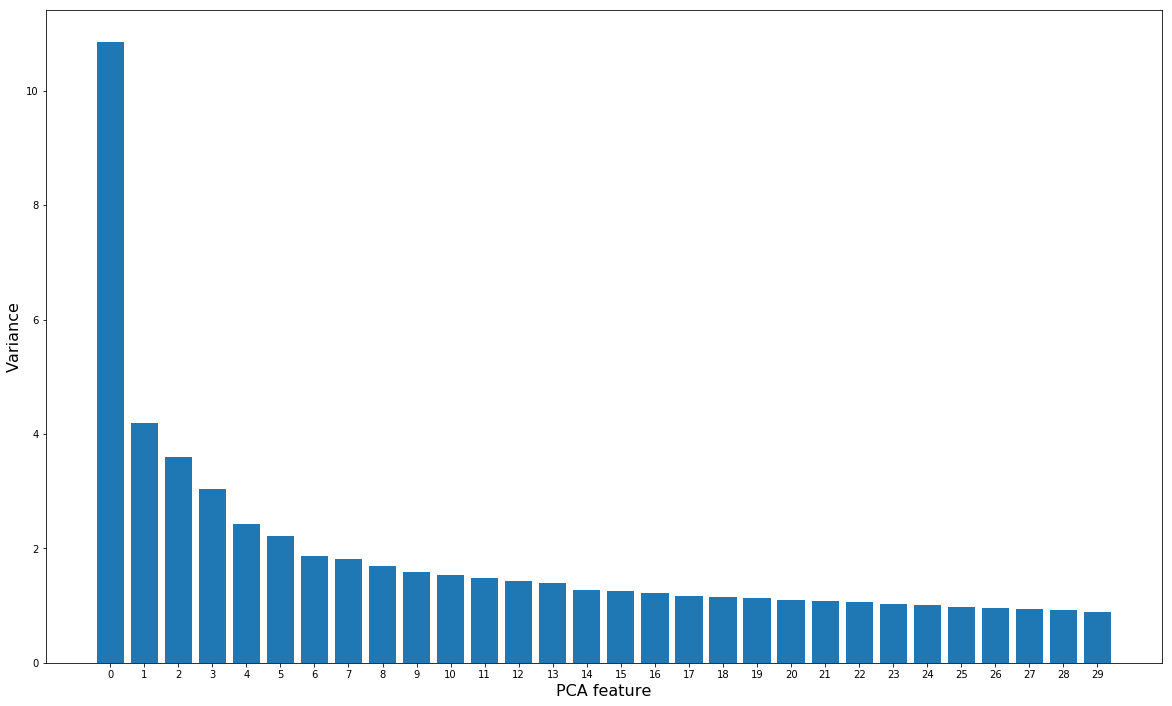

In [36]:
scaler = StandardScaler()
pca = PCA(30)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X_train, y_train)

features = range(pca.n_components_)
plt.figure(figsize=(20,12))
plt.bar(features, pca.explained_variance_)

plt.xlabel("PCA feature", fontsize=16)
plt.ylabel("Variance", fontsize=16)

plt.xticks(features)
plt.show()

Wydaje się, że 14 komponencie (na wykresie 13) zmiana wpływu nie jest już bardzo mocno istotna, a oszczędzi procesorowi masy obliczeń. Czyli optymalnie będzie przyjąć n_components = 13

# Budowa modeli regresyjnych

Do wyznaczenia najlepszych parametrów zostanie użyta w każdym przypadku metoda GridSearch. Uwaga: Liczba parametrów param_grid została ograniczona. Poniżej pozostawiono kombinacje zawierające najlepsze parametry, nie będące wartościami brzegowymi listy. Przy jednorazowym podaniu większej liczby parametrów dla niektórych modeli, algorytm niestety kończy się błędem 'Memory error' (ograniczenie pamięci komputera autora analizy).

In [37]:
kfold = KFold(n_splits=5, random_state=42)
pca = PCA(random_state=42, n_components=13)
scaler = StandardScaler()

## ElasticNet

In [38]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],
    'elasticnet__alpha': [0.001, 0.01, 0.05, 0.1, 1, 10],
}

polynomialfeatures = PolynomialFeatures()
elasticnet = ElasticNet(tol=0.1, random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, elasticnet)

grid_1 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_1.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_1 = time_learn_stop - time_learn_start
grid_1.best_params_

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 2}

## Lasso

In [39]:
param_grid = {
    'polynomialfeatures__degree': [2, 3, 4, 5, 6],
    'lasso__alpha': [200, 300, 400, 500],
}

polynomialfeatures = PolynomialFeatures()
lasso = Lasso(random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, lasso)

grid_2 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_2.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_2 = time_learn_stop - time_learn_start
grid_2.best_params_

{'lasso__alpha': 200, 'polynomialfeatures__degree': 6}

## Ridge

In [40]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],
    'ridge__alpha': [1, 10, 50, 100, 500, 1000], 
}

polynomialfeatures = PolynomialFeatures()
ridge = Ridge(random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, ridge)

grid_3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_3.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_3 = time_learn_stop - time_learn_start
grid_3.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 10}

## LinearRegression

In [41]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4], 
    }

polynomialfeatures = PolynomialFeatures()
linearregression = LinearRegression()

pipeline = make_pipeline(scaler, pca, polynomialfeatures, linearregression)

grid_4 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_4.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_4 = time_learn_stop - time_learn_start
grid_4.best_params_

{'polynomialfeatures__degree': 1}

## Random Forrest

In [42]:
param_grid = {
    'randomforestregressor__n_estimators': [250, 500, 750, 1000], # liczba drzew
    'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 
}

rfc = RandomForestRegressor(n_jobs=-1, oob_score = True, random_state=42) 
pipeline = make_pipeline(scaler, pca, rfc)

grid_5 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_5.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_5 = time_learn_stop - time_learn_start
grid_5.best_params_

{'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 750}

## XGBoost

In [43]:
param_grid = {
    'xgbregressor__n_estimators': [300, 500, 700, 900],
    'xgbregressor__max_depth' : [1, 2, 3], 
    'xgbregressor__learning_rate' : [0.01, 0.05, 0.1, 0.5]
}

xg_rg = XGBRegressor(colsample_bytree=0.4, gamma=0, min_child_weight=1.5, reg_alpha=0.75, reg_lambda=0.45, subsample=0.6,
                 seed=42)

pipeline = make_pipeline(scaler, pca, xg_rg)

grid_6 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, n_jobs=-1, scoring='r2')

time_learn_start = time.time()
grid_6.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_6 = time_learn_stop - time_learn_start
grid_6.best_params_

{'xgbregressor__learning_rate': 0.05,
 'xgbregressor__max_depth': 3,
 'xgbregressor__n_estimators': 700}

## Porównanie skuteczności modeli

In [44]:
models = []
models.append({"name":"ElasticNet", "model":grid_1.best_estimator_, "time":time_of_learning_1})
models.append({"name":'Lasso', "model":grid_2.best_estimator_, "time":time_of_learning_2})
models.append({"name":'Ridge', "model":grid_3.best_estimator_, "time":time_of_learning_3})
models.append({"name":'LR', "model":grid_4.best_estimator_, "time":time_of_learning_4})
models.append({"name":'RFR', "model":grid_5.best_estimator_, "time":time_of_learning_5})
models.append({"name":'XGB', "model":grid_6.best_estimator_, "time":time_of_learning_6})

Do porównania skuteczności modeli zostaną wykorzystane typowe miary dla regresji tj. R^2, Mediana błędu absolutnego, Średni błąd absolutny i Średni błąd absolutny procentowy.

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**************************************************
ElasticNet 

R^2: 0.874
Median absolute error: 0.073
Mean absolute error: 0.1
Mean absolute percentage error: 0.829


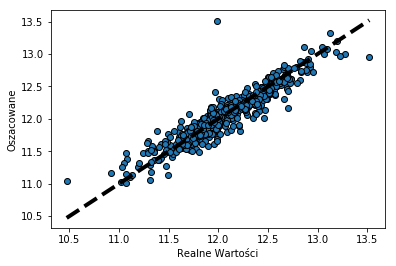

**************************************************
Lasso 

R^2: -10.395
Median absolute error: 0.226
Mean absolute error: 0.318
Mean absolute percentage error: 2.639


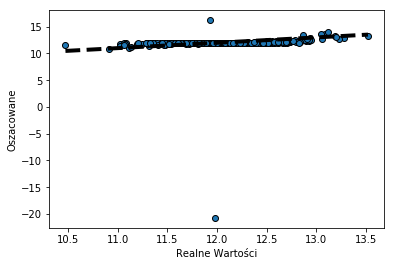

**************************************************
Ridge 

R^2: 0.823
Median absolute error: 0.077
Mean absolute error: 0.106
Mean absolute percentage error: 0.884


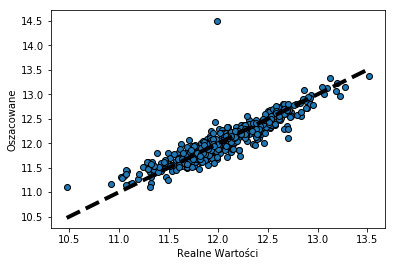

**************************************************
LR 

R^2: 0.823
Median absolute error: 0.077
Mean absolute error: 0.106
Mean absolute percentage error: 0.884


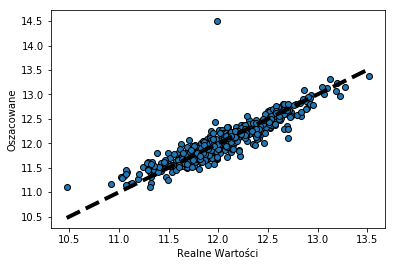

**************************************************
RFR 

R^2: 0.866
Median absolute error: 0.076
Mean absolute error: 0.105
Mean absolute percentage error: 0.873


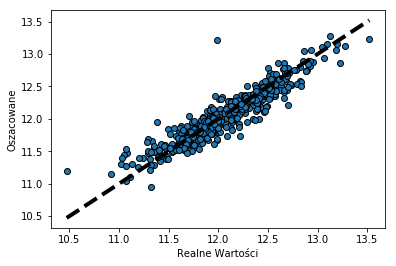

**************************************************
XGB 

R^2: 0.886
Median absolute error: 0.075
Mean absolute error: 0.1
Mean absolute percentage error: 0.835


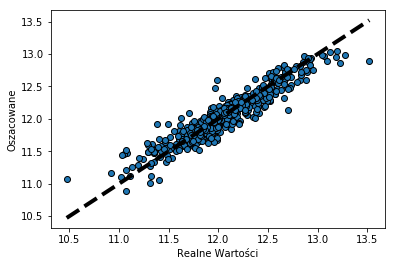

In [46]:
for alg in models:
    print("*"*50)
    print(alg["name"], "\n")
    print(f"R^2: {round(metrics.r2_score(y_test, alg['model'].predict(X_test)), 3)}")
    print(f"Median absolute error: {round(metrics.median_absolute_error(y_test, alg['model'].predict(X_test)), 3)}")
    print(f"Mean absolute error: {round(metrics.mean_absolute_error(y_test, alg['model'].predict(X_test)), 3)}")
    print(f"Mean absolute percentage error: {round(mean_absolute_percentage_error(y_test, alg['model'].predict(X_test)), 3)}")
    
    results = pd.DataFrame()
    results['actual'] = y_test
    results['predicted'] = alg['model'].predict(X_test)
    fig, ax = plt.subplots()
    ax.scatter(results['actual'], results['predicted'], edgecolors=(0, 0, 0))
    ax.plot([results['actual'].min(), results['actual'].max()], [results['actual'].min(), results['actual'].max()], 'k--', lw=4)
    ax.set_xlabel('Realne Wartości')
    ax.set_ylabel('Oszacowane')
    plt.show()

Wnioski:

* na etapie uczenia, badając kryterium R^2, najlepszym modelem okazał się 'XGBRegression'. R^2 na danych testowych wyszło najwyższe oraz uzyskał on również najniższy średni błąd absolutny procentowy.
* najgorszym modelem okazał się 'Lasso', wynik R^2 ujemny dyskwalifikuje go do jakichkolwiek dalszych rozwarzań. 

Warto również zwrócić uwagę na to, jak długo trwał trening poszczególnych modeli:

In [47]:
df_models = pd.DataFrame(models)[["name", "time"]]
df_models.set_index('name', inplace=True)

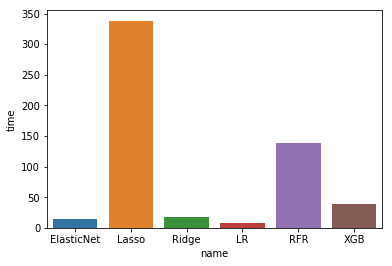

In [48]:
sns.barplot(x=df_models.index, y=df_models.time)

Wykres pokazuje, że najdłużej trenował się model Lasso, który jednocześnie miał najniższą skuteczność. Warto zestawić ze sobą czas uczenia ze skutecznością wyrażoną przez R^2. Z uwagi na fakt, że algorytm Lasso istotnie odstaje od reszty zostanie pominięty, gdyż zbyt mocno wpłynie na skalę.

In [49]:
r2 = []
for alg in models:
    r2.append(round(metrics.r2_score(y_test, alg['model'].predict(X_test)), 3))

In [50]:
df_models.insert(loc=0, column='R2', value=r2)

In [51]:
df_models = df_models.drop("Lasso")

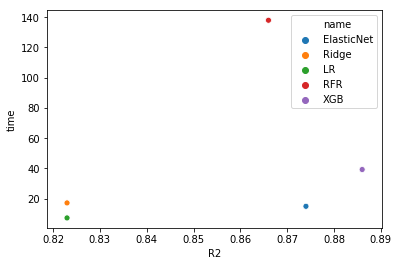

In [52]:
sns.scatterplot(df_models["R2"], df_models["time"], hue=df_models.index)

Podsumowując - Algorytm XGBoost Regression osiągnął najlepsze wyniki, jednak warto zaznaczyć, że był trzeci jeżeli chodzi o czas treningu. Biorąc jednak pod uwagę, że różnice nie były bardzo istotne, a w obecnych czasach przetwarzanie w chmurze jest coraz tańsze nie stanowi to wielkiego problemu. Kluczowym elementem powyższego zadania był preprocessing, dzięki któremu udało uniknąć się wielu problemów. 